## Word2Vec from Books 

"Duma i uprzedzenie" J. Austin

In [ ]:
!wget https://wolnelektury.pl/media/book/txt/conrad-jadro-ciemnosci.txt

--2021-05-07 12:28:05--  https://wolnelektury.pl/media/book/txt/conrad-jadro-ciemnosci.txt
Resolving wolnelektury.pl (wolnelektury.pl)... 51.83.143.148, 2001:41d0:602:3294::
Connecting to wolnelektury.pl (wolnelektury.pl)|51.83.143.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241205 (236K) [text/plain]
Saving to: ‘conrad-jadro-ciemnosci.txt.2’

conrad-jadro-ciemno 100%[===================>] 235.55K   734KB/s    in 0.3s    

2021-05-07 12:28:06 (734 KB/s) - ‘conrad-jadro-ciemnosci.txt.2’ saved [241205/241205]



In [ ]:
import re

In [ ]:
def quick_preproc(slowo):
  return bool(re.fullmatch(r'[a-zA-Z]+', slowo))

In [ ]:
sl = ["house", "I."]
[quick_preproc(s) for s in sl]

[True, False]

In [ ]:
lista_slow = []
with open('conrad-jadro-ciemnosci.txt', 'r') as f:
  for line in f:
    linia = line.strip().split()
    linia = [l for l in linia if quick_preproc(l) is True ]
    if linia is not []:
      lista_slow += linia

In [ ]:
lista_slow[1000:1050]

['wiele',
 'miejsc',
 'pustych',
 'na',
 'a',
 'z',
 'nich',
 'mi',
 'na',
 'mapie',
 'one',
 'wszystkie',
 'tak',
 'palec',
 'i',
 'jak',
 'biegun',
 'do',
 'tych',
 'nie',
 'tam',
 'a',
 'teraz',
 'nie',
 'Czar',
 'Inne',
 'miejsca',
 'rozrzucone',
 'w',
 'okolicach',
 'i',
 'po',
 'wszelkich',
 'geograficznych',
 'obu',
 'a',
 'nich',
 'nie',
 'o',
 'tym',
 'Ale',
 'tam',
 'jedno',
 'najbardziej',
 'tak',
 'powiem',
 'do',
 'mnie',
 'w',
 'owej']

In [ ]:
raw_text = lista_slow

In [ ]:
import torchtext 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

torch.manual_seed(1)

In [ ]:
TEXT = torchtext.legacy.data.Field(sequential=True)
LABEL = torchtext.legacy.data.Field()

datafields = [('text', TEXT), ('label', LABEL)]

In [ ]:
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))

In [ ]:
examples = []
for d in data:
    examples.append(torchtext.legacy.data.Example.fromlist([d[0], d[1]], datafields))


print(examples[1002].text)
print(examples[1002].label)
dataset = torchtext.legacy.data.Dataset(examples, datafields)


['pustych', 'na', 'z', 'nich']
['a']


In [ ]:
print(len(dataset))

15842


In [ ]:
train, valid, test = dataset.split([0.9, 0.05, 0.05])

In [ ]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [ ]:
my_vocab = list(set(raw_text))
print(my_vocab[:10])

['agent', 'mebli', 'wiem', 'ramieniem', 'niezmiernie', 'wolnych', 'Bo', 'niesamowite', 'Erith', 'ma']


In [ ]:
vocab_from_torch = TEXT.vocab
list_of_words = vocab_from_torch.itos
print(len(list_of_words))
print(list_of_words[:10])

3606
['<unk>', '<pad>', 'i', 'w', 'na', 'z', 'nie', 'do', 'to', 'o']


In [ ]:
from tqdm.auto import tqdm

In [ ]:
class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        self.dropout = nn.Dropout(0.35)
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs))
        out = self.linear1(embeds)
        out = self.dropout(out)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.LongTensor([word_to_id[word]])
        return self.embeddings(word).view(1,-1)

In [ ]:
EMDEDDING_DIM = 100
model = CBOW(len(TEXT.vocab), EMDEDDING_DIM)

loss_function = nn.NLLLoss()
 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
train_iterator = torchtext.legacy.data.Iterator(
        train,
        batch_size=128,
        repeat=False,
        sort_key=lambda x: len(x.text),
        train=True)

valid_iterator = torchtext.legacy.data.Iterator(
        valid,
        batch_size=128,
        repeat=False, 
        sort_key=lambda x: len(x.text),
        train=False)
 

In [ ]:
!pip install livelossplot


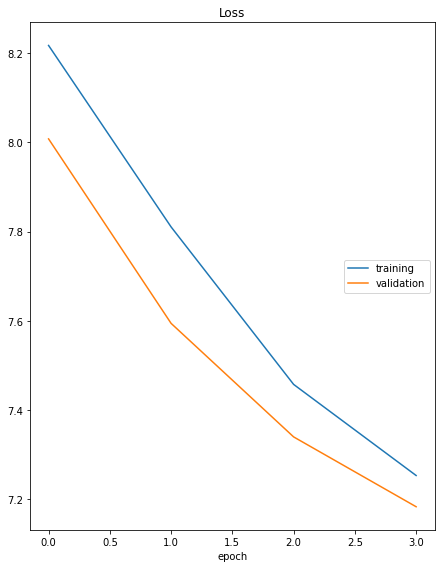

Loss
	training         	 (min:    7.253, max:    8.217, cur:    7.253)
	validation       	 (min:    7.184, max:    8.007, cur:    7.184)


In [ ]:
train_losses, test_losses = [],[]
EPOCH_NB = 4
from livelossplot import PlotLosses
liveloss = PlotLosses()

for epoch in range(EPOCH_NB):
  logs = {}
  print("\nEpoch: {} training\n".format(epoch))
  running_loss = 0
  for batch in tqdm(train_iterator):
    text, targets = batch.text, batch.label[0]
    model.zero_grad()
    log_probs = model(text)
    loss = loss_function(log_probs, targets)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() 

  test_loss = 0

  print("\nEpoch: {} validation\n".format(epoch))
  with torch.no_grad():
    for valid_batch in tqdm(valid_iterator):
      text, targets = valid_batch.text, valid_batch.label[0]
      log_ps = model(text)                              
      valid_loss = loss_function(log_ps, targets)        
      test_loss += valid_loss.item()



  train_losses.append(running_loss/len(train_iterator))
  test_losses.append(test_loss/len(valid_iterator))
  
  logs['loss'] = running_loss/len(train_iterator)
  logs['val_loss'] = test_loss/len(valid_iterator)
  liveloss.update(logs)
  liveloss.send()



# Nowa sekcja

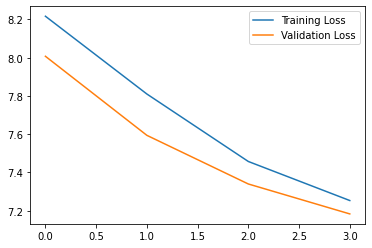

In [ ]:
  import matplotlib.pyplot as plt
  
  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Validation Loss')
  plt.legend(frameon=True)

In [ ]:
m = model.embeddings
emb = m.weight.detach().numpy()
print(emb.shape)

(3606, 100)


In [ ]:
from numpy import savetxt
savetxt('embeddings.tsv', emb, delimiter='\t')

In [ ]:
f=open('words.txt','w')
list_of_words=map(lambda x:x+'\n', list_of_words)
f.writelines(list_of_words)
f.close()